# 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define enhanced data transforms with augmentation
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load datasets
data_dir = '/kaggle/input/brain-tumor-mri-dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes
print(f"Classes: {class_names}")

# CWAM Module
class CWAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(CWAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# ResNet101 + CWAM Model
class ResNet101_CWAM(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101_CWAM, self).__init__()
        self.backbone = models.resnet101(weights='IMAGENET1K_V1')
        self.features = nn.Sequential(*list(self.backbone.children())[:-2])
        self.cwam = CWAM(2048)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.cwam(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model, loss, optimizer, and scheduler
model = ResNet101_CWAM(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = np.inf
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_loss = val_loss
            self.best_model_state = model.state_dict().copy()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_loss = val_loss
            self.best_model_state = model.state_dict().copy()
            self.counter = 0

# Training loop
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    train_acc_history, val_acc_history, train_loss_history, val_loss_history = [], [], [], []
    early_stopping = EarlyStopping(patience=5)

    print("Starting training...")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in dataloaders['Training']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(dataloaders['Training'])
        train_accuracy = 100 * correct / total
        train_acc_history.append(train_accuracy)
        train_loss_history.append(train_loss)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in dataloaders['Testing']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(dataloaders['Testing'])
        val_accuracy = 100 * val_correct / val_total
        val_acc_history.append(val_accuracy)
        val_loss_history.append(val_loss)

        # Scheduler step and early stopping
        scheduler.step(val_loss)
        early_stopping(val_loss, model)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
              
        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'class_names': class_names
        }, '/kaggle/working/model_checkpoint.pth')
        
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load the best model states (from early stopping)
    if early_stopping.best_model_state is not None:
        model.load_state_dict(early_stopping.best_model_state)
    
    # Save the final best model
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': class_names,
        'val_accuracy': val_accuracy,
        'num_classes': len(class_names)
    }, '/kaggle/working/brain_tumor_model.pth')
    print(f"Model saved to /kaggle/working/brain_tumor_model.pth")

    # Test accuracy
    model.eval()
    test_correct, test_total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloaders['Testing']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_accuracy = 100 * test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot accuracy and loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc_history, label='Train Accuracy', marker='o')
    plt.plot(val_acc_history, label='Validation Accuracy', marker='o')
    plt.title('Train vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss_history, label='Train Loss', marker='o')
    plt.plot(val_loss_history, label='Validation Loss', marker='o')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_plots.png')
    plt.show()

# Run training
train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Using device: cpu


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

 10%|▉         | 16.5M/171M [00:00<00:00, 173MB/s]

 21%|██        | 35.8M/171M [00:00<00:00, 189MB/s]

 32%|███▏      | 55.1M/171M [00:00<00:00, 195MB/s]

 44%|████▍     | 75.8M/171M [00:00<00:00, 203MB/s]

 56%|█████▌    | 95.2M/171M [00:00<00:00, 201MB/s]

 68%|██████▊   | 115M/171M [00:00<00:00, 203MB/s] 

 79%|███████▉  | 134M/171M [00:00<00:00, 202MB/s]

 91%|█████████ | 154M/171M [00:00<00:00, 204MB/s]

100%|██████████| 171M/171M [00:00<00:00, 200MB/s]

/usr/local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training...


Epoch 1/20, Train Loss: 0.2544, Train Acc: 91.60%, Val Loss: 0.2138, Val Acc: 92.75%


Epoch 2/20, Train Loss: 0.1218, Train Acc: 95.90%, Val Loss: 0.1268, Val Acc: 94.51%


Epoch 3/20, Train Loss: 0.0793, Train Acc: 97.34%, Val Loss: 0.0634, Val Acc: 98.02%


Epoch 4/20, Train Loss: 0.0633, Train Acc: 98.04%, Val Loss: 0.0656, Val Acc: 98.09%


Epoch 5/20, Train Loss: 0.0502, Train Acc: 98.37%, Val Loss: 0.0381, Val Acc: 98.86%


Epoch 6/20, Train Loss: 0.0490, Train Acc: 98.44%, Val Loss: 0.0747, Val Acc: 97.18%


Epoch 7/20, Train Loss: 0.0461, Train Acc: 98.65%, Val Loss: 0.0270, Val Acc: 99.08%


Epoch 8/20, Train Loss: 0.0385, Train Acc: 98.86%, Val Loss: 0.0236, Val Acc: 99.31%


Epoch 9/20, Train Loss: 0.0286, Train Acc: 99.09%, Val Loss: 0.0308, Val Acc: 99.24%


Epoch 10/20, Train Loss: 0.0265, Train Acc: 99.02%, Val Loss: 0.0151, Val Acc: 99.47%


Epoch 11/20, Train Loss: 0.0229, Train Acc: 99.18%, Val Loss: 0.0380, Val Acc: 99.01%


Epoch 12/20, Train Loss: 0.0239, Train Acc: 99.23%, Val Loss: 0.0157, Val Acc: 99.47%


Epoch 13/20, Train Loss: 0.0284, Train Acc: 99.04%, Val Loss: 0.0458, Val Acc: 98.55%


Epoch 14/20, Train Loss: 0.0373, Train Acc: 98.69%, Val Loss: 0.0304, Val Acc: 99.16%


Epoch 15/20, Train Loss: 0.0115, Train Acc: 99.67%, Val Loss: 0.0141, Val Acc: 99.62%


Epoch 16/20, Train Loss: 0.0060, Train Acc: 99.82%, Val Loss: 0.0139, Val Acc: 99.69%


Epoch 17/20, Train Loss: 0.0029, Train Acc: 99.91%, Val Loss: 0.0160, Val Acc: 99.62%


Epoch 18/20, Train Loss: 0.0059, Train Acc: 99.79%, Val Loss: 0.0261, Val Acc: 99.31%


Epoch 19/20, Train Loss: 0.0050, Train Acc: 99.82%, Val Loss: 0.0115, Val Acc: 99.69%


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# CWAM Module definition
class CWAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(CWAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# ResNet101 + CWAM Model
class ResNet101_CWAM(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101_CWAM, self).__init__()
        self.backbone = models.resnet101(weights='IMAGENET1K_V1')
        self.features = nn.Sequential(*list(self.backbone.children())[:-2])
        self.cwam = CWAM(2048)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.cwam(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def predict_image(image_path, model_path='/kaggle/working/brain_tumor_model.pth'):
    """
    Load a trained model and make a prediction on a single image
    """
    try:
        # Load checkpoint
        checkpoint = torch.load(model_path, map_location=device)
        
        # Extract model info
        class_names = checkpoint['class_names']
        num_classes = checkpoint['num_classes']
        
        # Initialize model
        model = ResNet101_CWAM(num_classes=num_classes).to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        print(f"Model loaded successfully with classes: {class_names}")
        
        # Image preprocessing
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Load and preprocess the image
        img = Image.open(image_path).convert('RGB')
        input_tensor = preprocess(img).unsqueeze(0).to(device)
        
        # Make prediction
        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)[0]
            predicted_class_idx = torch.argmax(output, 1).item()
            predicted_class = class_names[predicted_class_idx]
            confidence = probabilities[predicted_class_idx].item() * 100
        
        # Display results
        plt.figure(figsize=(12, 5))
        
        # Display image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}%")
        plt.axis('off')
        
        # Display probability bar chart
        plt.subplot(1, 2, 2)
        probs = probabilities.cpu().numpy()
        y_pos = np.arange(len(class_names))
        
        bars = plt.barh(y_pos, probs * 100)
        plt.yticks(y_pos, class_names)
        plt.xlabel('Probability (%)')
        plt.title('Class Probabilities')
        
        # Highlight the predicted class
        bars[predicted_class_idx].set_color('red')
        
        plt.tight_layout()
        plt.savefig('/kaggle/working/prediction_result.png')
        plt.show()
        
        # Print prediction results
        print(f"\nPrediction Summary:")
        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")
        print("\nClass Probabilities:")
        for i, class_name in enumerate(class_names):
            print(f"{class_name}: {probs[i] * 100:.2f}%")
            
        return {
            'prediction': predicted_class,
            'confidence': confidence,
            'probabilities': {class_names[i]: probs[i] * 100 for i in range(len(class_names))}
        }
        
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

def batch_predict(image_folder, model_path='/kaggle/working/brain_tumor_model.pth'):
    """
    Make predictions on multiple images in a folder
    """
    try:
        # Load checkpoint
        checkpoint = torch.load(model_path, map_location=device)
        
        # Extract model info
        class_names = checkpoint['class_names']
        num_classes = checkpoint['num_classes']
        
        # Initialize model
        model = ResNet101_CWAM(num_classes=num_classes).to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        print(f"Model loaded successfully with classes: {class_names}")
        
        # Image preprocessing
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Get all image files
        valid_extensions = ['.jpg', '.jpeg', '.png']
        image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) 
                      if os.path.splitext(f)[1].lower() in valid_extensions]
        
        if not image_paths:
            print(f"No valid images found in {image_folder}")
            return
        
        results = {}
        
        # Process each image
        for img_path in image_paths:
            filename = os.path.basename(img_path)
            print(f"Processing {filename}...")
            
            try:
                # Load and preprocess the image
                img = Image.open(img_path).convert('RGB')
                input_tensor = preprocess(img).unsqueeze(0).to(device)
                
                # Make prediction
                with torch.no_grad():
                    output = model(input_tensor)
                    probabilities = torch.nn.functional.softmax(output, dim=1)[0]
                    predicted_class_idx = torch.argmax(output, 1).item()
                    predicted_class = class_names[predicted_class_idx]
                    confidence = probabilities[predicted_class_idx].item() * 100
                
                results[filename] = {
                    'prediction': predicted_class,
                    'confidence': confidence
                }
                
                print(f"  Prediction: {predicted_class}, Confidence: {confidence:.2f}%")
                
            except Exception as e:
                print(f"  Error processing {filename}: {e}")
        
        return results
            
    except Exception as e:
        print(f"Error during batch prediction: {e}")
        return None

# Usage example
if __name__ == "__main__":
    # Replace with path to your image
    image_path = '/kaggle/input/picture2/picture2.jpg'  # Update this path
    
    if os.path.exists(image_path):
        print(f"Making prediction on {image_path}...")
        prediction_result = predict_image(image_path)
    else:
        print(f"Image not found at {image_path}. Please upload an image first.")
        
    # Uncomment the following lines if you want to run batch prediction on a folder of images
    # image_folder = '/kaggle/working/test_images'  # Folder containing multiple images
    # if os.path.exists(image_folder) and os.path.isdir(image_folder):
    #     print(f"Making predictions on images in {image_folder}...")
    #     batch_results = batch_predict(image_folder)
    # else:
    #     print(f"Folder not found: {image_folder}")

In [6]:
import matplotlib.pyplot as plt

def plot_training_graphs(train_acc_history, val_acc_history, train_loss_history, val_loss_history, output_path='training_plots.png'):
    """
    Plot training and validation accuracy and loss graphs.
    
    Args:
        train_acc_history (list): List of training accuracy values per epoch
        val_acc_history (list): List of validation accuracy values per epoch
        train_loss_history (list): List of training loss values per epoch
        val_loss_history (list): List of validation loss values per epoch
        output_path (str): Path to save the plot
    """
    # Create figure with two subplots
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_acc_history, label='Train Accuracy', marker='o')
    plt.plot(val_acc_history, label='Validation Accuracy', marker='o')
    plt.title('Train vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss_history, label='Train Loss', marker='o')
    plt.plot(val_loss_history, label='Validation Loss', marker='o')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()
    print(f"Training graphs saved to {output_path}")

# Example usage (replace with actual history data from training)
if __name__ == "__main__":
    # Sample data from the notebook's output (for demonstration)
    train_acc_history = [91.60, 95.90, 97.34, 98.04, 98.37, 98.44, 98.65, 98.86, 99.09, 99.02, 99.18, 99.23, 99.04, 98.69, 99.67, 99.82, 99.91, 99.79, 99.82]
    val_acc_history = [92.75, 94.51, 98.02, 98.09, 98.86, 97.18, 99.08, 99.31, 99.24, 99.47, 99.01, 99.47, 98.55, 99.16, 99.62, 99.69, 99.62, 99.31, 99.69]
    train_loss_history = [0.2544, 0.1218, 0.0793, 0.0633, 0.0502, 0.0490, 0.0461, 0.0385, 0.0286, 0.0265, 0.0229, 0.0239, 0.0284, 0.0373, 0.0115, 0.0060, 0.0029, 0.0059, 0.0050]
    val_loss_history = [0.2138, 0.1268, 0.0634, 0.0656, 0.0381, 0.0747, 0.0270, 0.0236, 0.0308, 0.0151, 0.0380, 0.0157, 0.0458, 0.0304, 0.0141, 0.0139, 0.0160, 0.0261, 0.0115]
    
    plot_training_graphs(train_acc_history, val_acc_history, train_loss_history, val_loss_history, output_path='training_plots.png')

Training graphs saved to training_plots.png


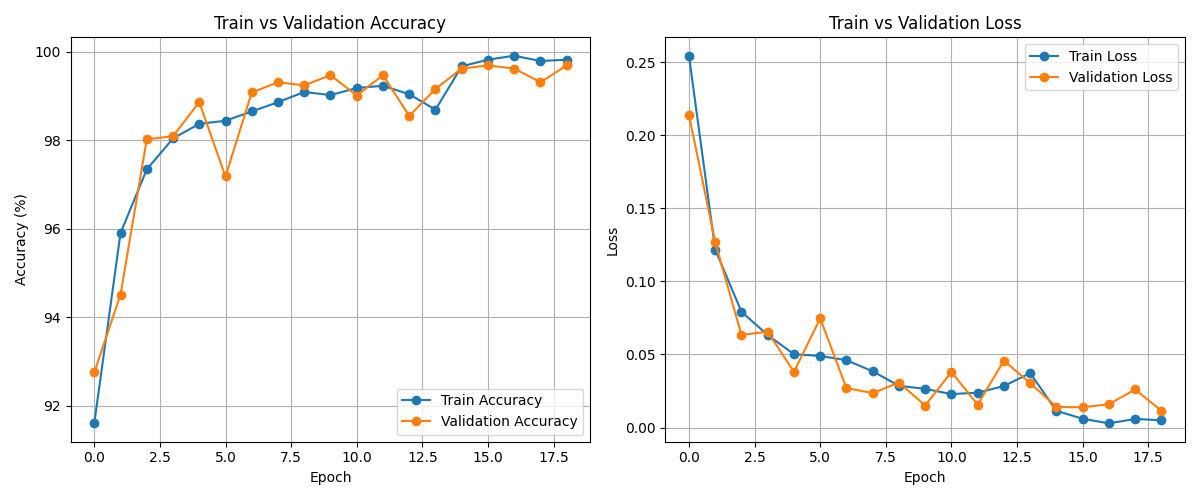

In [7]:
from IPython.display import Image, display
display(Image(filename='training_plots.png'))

In [5]:
import torch
from sklearn.metrics import classification_report
import numpy as np

def print_evaluation_metrics(test_loader, model, class_names, device):
    model.eval()
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())
    
    report = classification_report(true_labels, pred_labels, target_names=class_names, digits=4)
    print("\nClassification Report:")
    print(report)
    
    return report

Using device: cuda
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training model...
Starting training...
Epoch 1/10, Train Loss: 0.2623, Train Acc: 90.97%, Val Loss: 0.0798, Val Acc: 97.56%
Epoch 2/10, Train Loss: 0.0997, Train Acc: 96.59%, Val Loss: 0.1327, Val Acc: 95.12%
Epoch 3/10, Train Loss: 0.0784, Train Acc: 97.43%, Val Loss: 0.0870, Val Acc: 97.33%
Epoch 4/10, Train Loss: 0.0691, Train Acc: 97.81%, Val Loss: 0.0896, Val Acc: 97.71%
Epoch 5/10, Train Loss: 0.0554, Train Acc: 98.39%, Val Loss: 0.0577, Val Acc: 97.64%
Epoch 6/10, Train Loss: 0.0359, Train Acc: 98.91%, Val Loss: 0.0373, Val Acc: 99.16%
Epoch 7/10, Train Loss: 0.0438, Train Acc: 98.46%, Val Loss: 0.0905, Val Acc: 96.57%
Epoch 8/10, Train Loss: 0.0328, Train Acc: 98.98%, Val Loss: 0.0218, Val Acc: 99.16%
Epoch 9/10, Train Loss: 0.0344, Train Acc: 98.86%, Val Loss: 0.0679, Val Acc: 97.33%
Epoch 10/10, Train Loss: 0.0285, Train Acc: 98.95%, Val Loss: 0.0380, Val Acc: 98.63%
Model saved to /kaggle/working/br

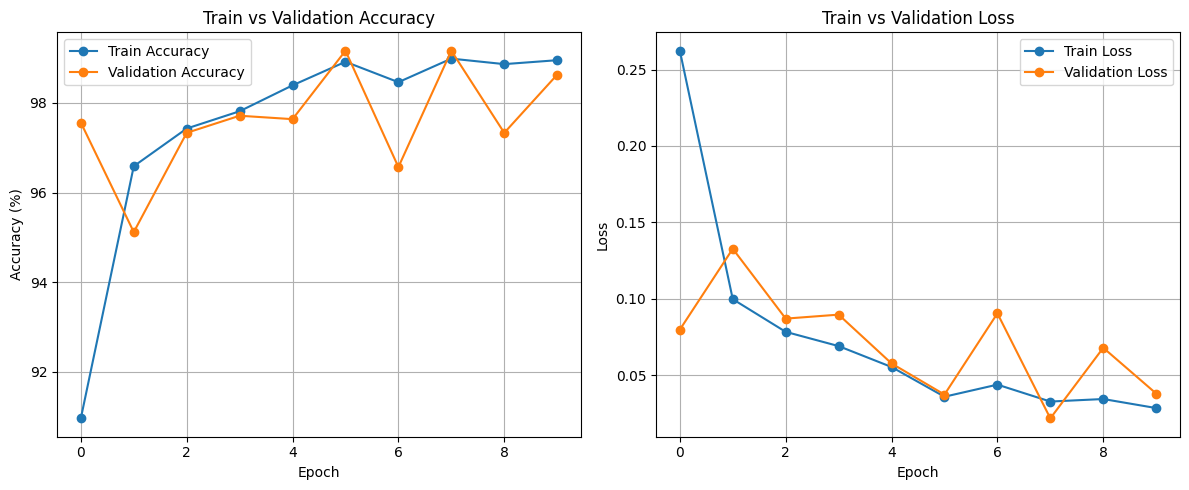

In [14]:
import matplotlib
#matplotlib.use('inline')  # Force inline backend for Jupyter/Kaggle
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transforms
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load datasets
data_dir = '/kaggle/input/brain-tumor-mri-dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes
print(f"Classes: {class_names}")

# CWAM Module
class CWAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(CWAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# ResNet101 + CWAM Model
class ResNet101_CWAM(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101_CWAM, self).__init__()
        self.backbone = models.resnet101(weights='IMAGENET1K_V1')
        self.features = nn.Sequential(*list(self.backbone.children())[:-2])
        self.cwam = CWAM(2048)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.cwam(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = np.inf
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_loss = val_loss
            self.best_model_state = model.state_dict().copy()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_loss = val_loss
            self.best_model_state = model.state_dict().copy()
            self.counter = 0

# Training function
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=10):
    train_acc_history, val_acc_history, train_loss_history, val_loss_history = [], [], [], []
    early_stopping = EarlyStopping(patience=5)
    
    print("Starting training...")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in dataloaders['Training']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(dataloaders['Training'])
        train_accuracy = 100 * correct / total
        train_acc_history.append(train_accuracy)
        train_loss_history.append(train_loss)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in dataloaders['Testing']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(dataloaders['Testing'])
        val_accuracy = 100 * val_correct / val_total
        val_acc_history.append(val_accuracy)
        val_loss_history.append(val_loss)

        # Scheduler and early stopping
        scheduler.step(val_loss)
        early_stopping(val_loss, model)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load and save the best model
    if early_stopping.best_model_state is not None:
        model.load_state_dict(early_stopping.best_model_state)
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': class_names,
        'num_classes': len(class_names)
    }, '/kaggle/working/brain_tumor_model.pth')
    print(f"Model saved to /kaggle/working/brain_tumor_model.pth")

    # Save training history
    history = {
        'train_acc': train_acc_history,
        'val_acc': val_acc_history,
        'train_loss': train_loss_history,
        'val_loss': val_loss_history
    }
    with open('/kaggle/working/training_history.pkl', 'wb') as f:
        pickle.dump(history, f)
    print("Training history saved to /kaggle/working/training_history.pkl")
    
    return model, history

# Function to evaluate model and print classification report
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print classification report
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    print(report)
    return report

# Function to plot accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(history['val_acc'], label='Validation Accuracy', marker='o')
    plt.title('Train vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_plots.png')
    print("Plot saved to /kaggle/working/training_plots.png")
    plt.show()

# Main execution
print("Training model...")
model = ResNet101_CWAM(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Train model and get history
model, history = train_model(model, criterion, optimizer, scheduler, dataloaders)

# Evaluate model
evaluate_model(model, dataloaders['Testing'], class_names)

# Plot training history
plot_training_history(history)

In [15]:
!ls /kaggle/working/

brain_tumor_model.pth  training_history.pkl  training_plots.png


In [16]:
from IPython.display import FileLink
FileLink('/kaggle/working/brain_tumor_model.pth')
FileLink('/kaggle/working/training_history.pkl')
FileLink('/kaggle/working/training_plots.png')

/kaggle/working/training_plots.png

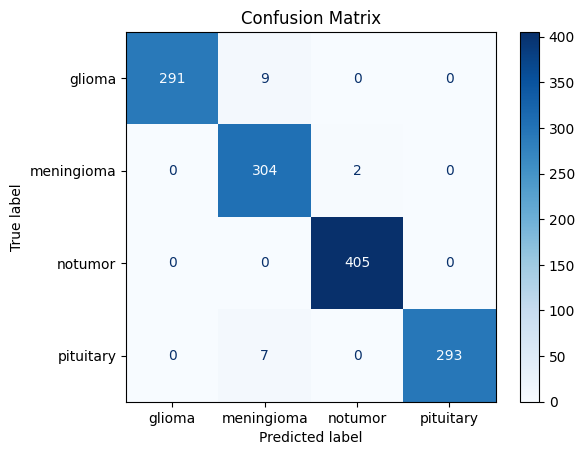

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

# Call the function
plot_confusion_matrix(model, dataloaders['Testing'], class_names)


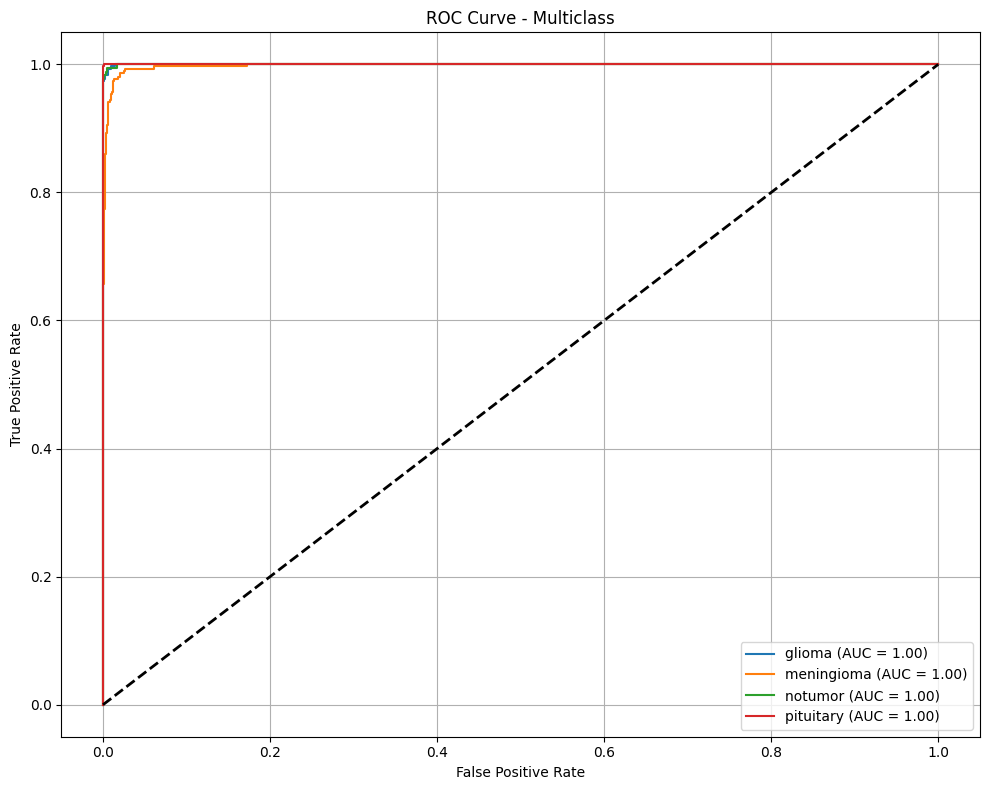

In [18]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

def plot_roc_auc(model, test_loader, class_names):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_scores.extend(outputs.cpu().numpy())
            y_true.extend(labels.numpy())

    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    y_scores = np.array(y_scores)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multiclass')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_roc_auc(model, dataloaders['Testing'], class_names)


Selected image: /kaggle/input/pic-gli/pic_gli.jpg
Predicted class: notumor
Class probabilities:
glioma: 0.0009
meningioma: 0.0030
notumor: 0.9961
pituitary: 0.0001


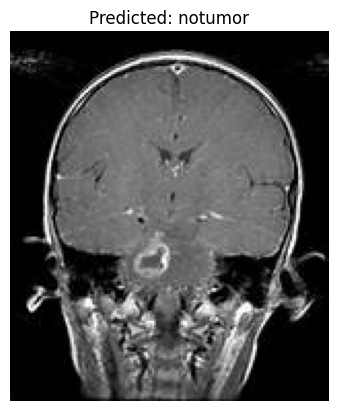

In [22]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np

# Prediction function
def predict_from_directory(image_dir, model, class_names, device):
    model.eval()

    # Get the first image file in the directory
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print("No image files found in the directory.")
        return
    
    image_path = os.path.join(image_dir, image_files[0])
    img = Image.open(image_path).convert("RGB")

    # Image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted_class = class_names[np.argmax(probs)]

    # Display results
    print(f"Selected image: {image_path}")
    print(f"Predicted class: {predicted_class}")
    print("Class probabilities:")
    for cls, p in zip(class_names, probs):
        print(f"{cls}: {p:.4f}")

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage
predict_from_directory("/kaggle/input/pic-gli", model, class_names, device)
